In [1]:
library(SBC);
library(cmdstanr);
library(jsonlite);
library(tidyverse);
options(mc.cores = parallel::detectCores());
library(future);
plan(multisession);

options(SBC.min_chunk_size = 5);

cache_dir <- "./SBC_cache"
if(!dir.exists(cache_dir)) {
    dir.create(cache_dir)
}

ALPHA <- 0.05
model_KN <- cmdstanr::cmdstan_model("../models/Karlis_and_Ntzoufras.stan")

This is cmdstanr version 0.7.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/igor.michels/.cmdstan/cmdstan-2.34.1

- CmdStan version: 2.34.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
data_generator_single_KN <- function(n_clubs){
    n_seasons <- 1
    clubs <- sprintf("Club %02d", 1:n_clubs)
    clubs <- 1:n_clubs

    mu <- rnorm(1)
    h <- rnorm(2)
    a <- rnorm(length(clubs))
    d <- rnorm(length(clubs))
    ha <- rnorm(2 * length(clubs))
    hd <- rnorm(2 * length(clubs))

    df <- data.frame(Club = clubs)
    data <- merge(df, df, by = NULL) %>% filter(Club.x != Club.y)
    data <- data %>% slice(rep(row_number(), n_seasons))
    data$home.goals <- 0
    data$away.goals <- 0
    names(data) <- c("home_name", "away_name", "home_goals", "away_goals")

    for(i in 1:nrow(data)) {
        club_1 <- data[i, 1]
        club_2 <- data[i, 2]
        
        log_lambda_1jk <- mu + h[1] + a[club_1] + d[club_2] + ha[club_1] + hd[n_clubs + club_2]
        log_lambda_2jk <- mu + h[2] + a[club_2] + d[club_1] + ha[n_clubs + club_2] + hd[club_1]
        
        lambda_1jk <- exp(log_lambda_1jk)
        lambda_2jk <- exp(log_lambda_2jk)
        
        data[i, 3] <- rpois(1, lambda_1jk)
        data[i, 4] <- rpois(1, lambda_2jk)
    }

    list(
        variables = list(
            mu = mu,
            h = h,
            a = a,
            d = d,
            ha = ha,
            hd = hd
        ),
        generated = list(
            n_games = nrow(data),
            n_clubs = n_clubs,
            club_1 = data$home_name,
            club_2 = data$away_name,
            goals_club_1 = data$home_goals,
            goals_club_2 = data$away_goals
        )
    )
}

In [3]:
set.seed(0)
n_sims <- 250
data_generator_KN <- SBC_generator_function(data_generator_single_KN, n_clubs = 20)
dataset_KN <- generate_datasets(data_generator_KN, n_sims)
backend_KN <- SBC_backend_cmdstan_sample(model_KN, iter_warmup = 2000,
                                         iter_sampling = 2500, chains = 4)

results_KN <- compute_SBC(dataset_KN, backend_KN,
                          cache_mode = "results",
                          cache_location = file.path(cache_dir, "results_Karlis_and_Ntzoufras"))
    
write.csv(results_KN$stats,
          file = "SBC_cache/results_Karlis_and_Ntzoufras.csv")

Results loaded from cache file 'results_Karlis_and_Ntzoufras'

 - 1 (0%) fits had at least one Rhat > 1.01. Largest Rhat was 1.013.

 - 98 (39%) fits had iterations that saturated max treedepth. Maximum number of max treedepth was 10000.

Not all diagnostics are OK.
You can learn more by inspecting $default_diagnostics, $backend_diagnostics 
and/or investigating $outputs/$messages/$warnings for detailed output from the backend.



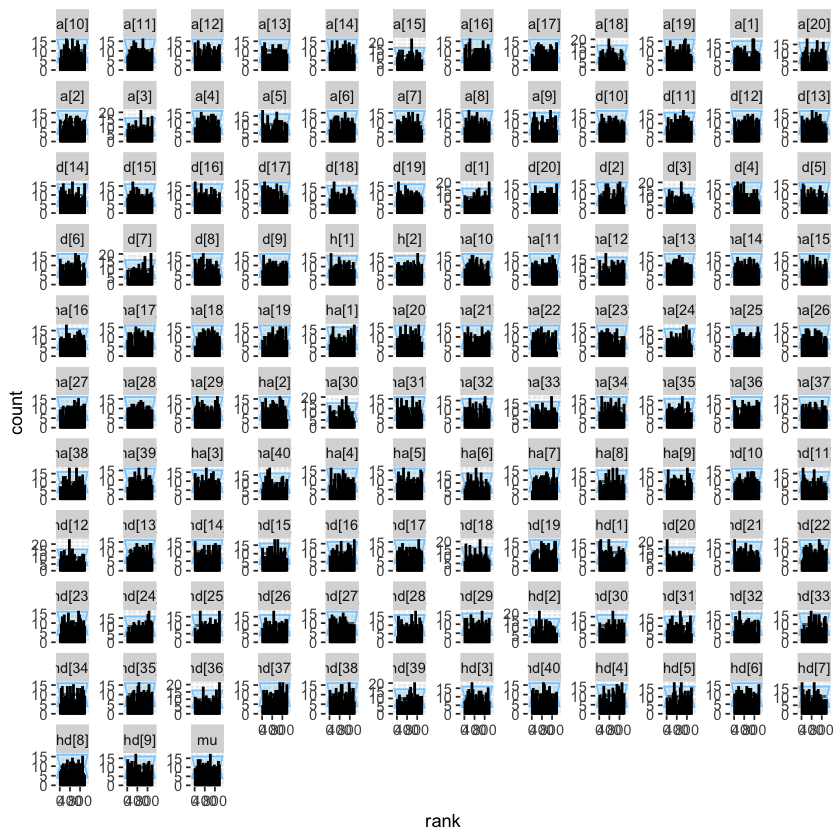

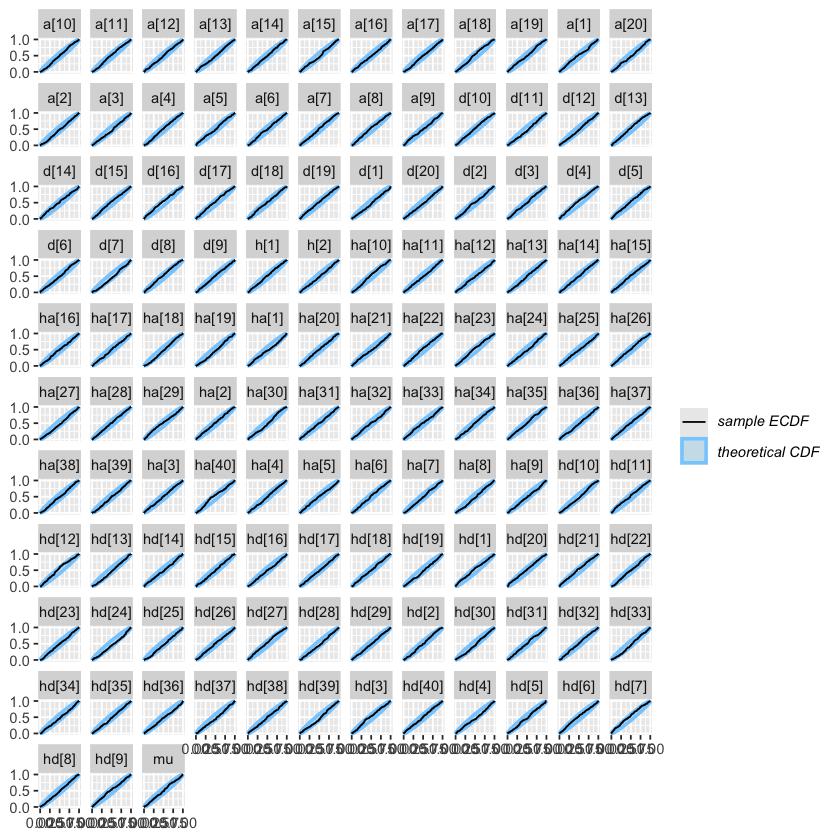

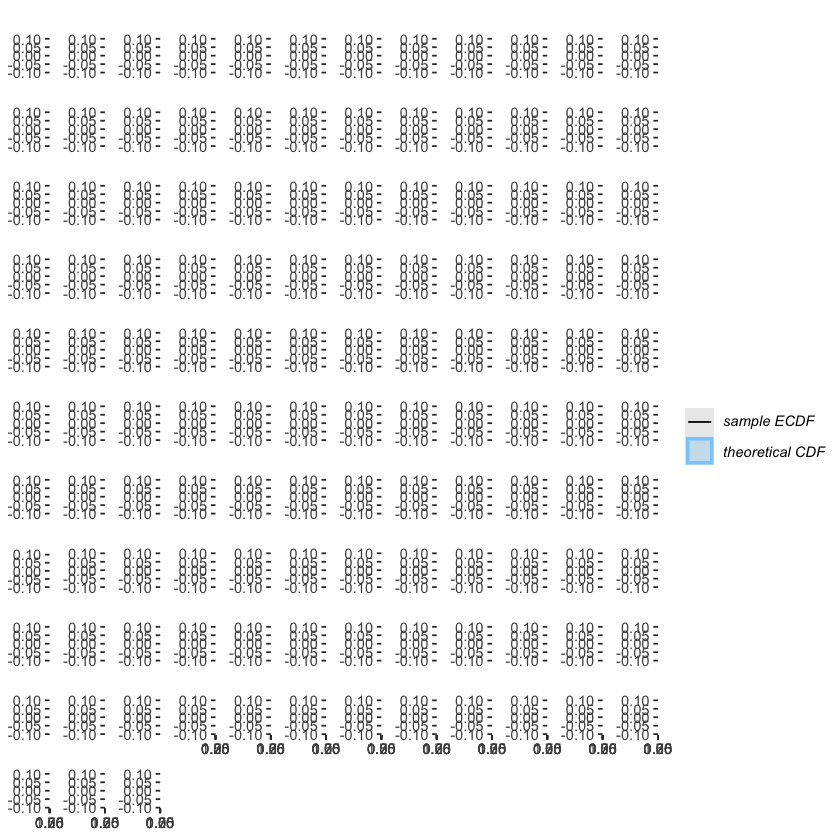

In [4]:
plot_rank_hist(results_KN)
plot_ecdf(results_KN)
plot_ecdf_diff(results_KN)

In [5]:
results <- results_KN
graph <- plot_ecdf(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df1 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df1$out <- (df1$ymax < df1$y) + (df1$ymin > df1$y)
df1 <- df1 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df1$out_ratio <- df1$out_ratio / length(unique(ecdf$x))
df1$out <- df1$out_ratio > ALPHA

graph <- plot_ecdf_diff(results)
plot_data <- ggplot_build(graph)$data
confidence_interval <- plot_data[[1]]
ecdf <- plot_data[[2]]

df2 <- merge(select(confidence_interval, - c(colour, fill, group, flipped_aes, linewidth, linetype, alpha, y)),
             select(ecdf, - c(colour, fill, group, linewidth, linetype, alpha)),
             by = c("PANEL", "x"), all.x = TRUE) %>%
       group_by(PANEL, x) %>%
       summarize(ymax = max(ymax, na.rm = TRUE),
                 ymin = max(ymin, na.rm = TRUE),
                 y = max(y, na.rm = TRUE))

df2$out <- (df2$ymax < df2$y) + (df2$ymin > df2$y)
df2 <- df2 %>% group_by(PANEL) %>% summarise(out_ratio = sum(out))
df2$out_ratio <- df2$out_ratio / length(unique(ecdf$x))
df2$out <- df2$out_ratio > ALPHA

final_df <- merge(df1, df2, by = "PANEL", suffixes = c("", "_diff"))
c(mean(as.numeric(final_df$out)), mean(as.numeric(final_df$out_diff)))

`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'PANEL'. You can override using the
`.groups` argument.


[1] 0 0

In [6]:
data <- read_json('../real_data/KN_model_data.json')

fit_KN <- model_KN$sample(
  data = data,
  chains = 4,
  parallel_chains = 4,
  refresh = 500
)

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 4 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 4 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 4 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iterati

In [7]:
fit_KN$summary(
  variables = NULL,
  posterior::default_summary_measures(),
  extra_quantiles = ~posterior::quantile2(., probs = c(.0275, .975))
)

variable,mean,median,sd,mad,q5,q95,q2.75,q97.5
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-726.87076950,-726.52650000,7.9284169,8.1090807,-740.5863000,-714.4164000,-742.9679900,-712.5761000
mu,0.06289688,0.06966310,0.6322487,0.6349116,-0.9900264,1.1043960,-1.1714251,1.3017270
h[1],0.15997915,0.17000750,0.6286838,0.6327863,-0.8560890,1.1924365,-1.0293003,1.4060628
h[2],-0.10183680,-0.11094700,0.6327163,0.6241427,-1.1580590,0.9594528,-1.3140564,1.1399188
a[1],0.13170056,0.14424100,0.6127419,0.6082693,-0.8814251,1.1469085,-1.0444883,1.3211050
a[2],-0.05977843,-0.06889520,0.6234242,0.6099820,-1.0748870,0.9735103,-1.2519789,1.1707480
a[3],0.14892659,0.15766900,0.5994036,0.5899154,-0.8565122,1.1137205,-1.0233091,1.3054365
a[4],-0.16352059,-0.16148700,0.6091353,0.6060387,-1.1798670,0.8120601,-1.3267270,0.9873551
a[5],0.23116682,0.23272750,0.6132643,0.6111114,-0.7634443,1.2482605,-0.9179473,1.4321758
